In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils.visualizer as uv
import utils.engine as ue
from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [4]:
plt.rcParams["animation.html"] = "jshtml"

## Эээээээээксперименты

### 0. Линейный профиль с закрепленными концами

In [ ]:
Tis_init = -20.0
ice_thickness_init = 2.0
Ti_func_init = lambda z: (z*Tis_init + (ice_thickness_init-z)*ue.Tf_w)/ice_thickness_init - \
                          5*np.sin(2*np.pi/ice_thickness_init*z)


T_atm = lambda time: -30.0 
u_a = lambda time: 15.0
F_ocn = lambda T, time: 0.0
F_sw = lambda time: 100.0
F_lw = lambda T_atm: ue.sigma*(T_atm + 273.15)**4
F_atm = lambda T, time: (1 - ue.albedo_i)*(1 - ue.i0_i)*F_sw(time)\
                        + ue.rho_a*ue.c_pa*ue.C_sh*u_a(time)*(T_atm(time) - T)\
                        + ue.emissivity*(F_lw(T_atm(time)) - ue.sigma*(T + 273.15)**4)

Ni = 20
Ns = 10
dzi_init = np.arange(Ni, 0, -1)/sum(np.arange(Ni, 0, -1))*ice_thickness_init
ice_cells_init = dzi_init.cumsum() - dzi_init/2
salinity_init = np.full(Ni, 3.0)

In [ ]:
process_linear = ue.main_process\
(
    time_step=3600,
    time_end=3600*250,
    N_pseudoiter=25,
    Ti_init=Ti_func_init(ice_cells_init),
    Ts_init=np.array([np.nan]*10),
    Toi_init=ue.Tf_w,
    Tis_init=Tis_init,
    Tsa_init=np.nan,
    dzi_init=dzi_init,
    dzs_init=np.ones(10)*0,
    salinity=salinity_init,
    snow_thickness_threshold=0.05,
    Ta=T_atm, # lambda time: ...
    p=lambda time: 0.0, # lambda time: ...
    F_atm_ice=F_atm, # lambda T, time: ...
    F_atm_snow=lambda T, time: 0.0, # lambda T, time: ...
    F_sw=F_sw, # lambda time: ...
    F_ocn=F_ocn, # lambda T, time: ...
#     Ns=10
)

In [ ]:
uv.timeseries_img(process_linear, ue.rho_w, ue.rho_s)

In [ ]:
vis_0 = uv.animate([process_linear], ue.rho_w, ue.rho_s,
                   clip_start=10, clip_end=85)

In [ ]:
vis_0

### 0. Аналитическое задание функций потока

In [ ]:
# какие-то функции для температур атмосферы и океана
T_ocn = lambda time: ue.Tf_w
T_atm = lambda time: -30.0

# коротковолновая радиация
F_sw = lambda time: 100.0

# длинноволновая радиация
F_lw = lambda T: ue.sigma*(T + 273.15)**4

# какая-то функция для скорости ветра
u_a = lambda time: 15.0

# поток в лед
F_atm_ice = lambda T, time:  (1 - ue.albedo_i)*(1 - ue.i0_i)*F_sw(time)\
                             + ue.rho_a*ue.c_pa*ue.C_sh*u_a(time)*(T_atm(time) - T)\
                             + ue.emissivity*(F_lw(T_atm(time)) - ue.sigma*(T + 273.15)**4)

# поток в снег
F_atm_snow = lambda T, time:  (1 - ue.albedo_s)*(1 - ue.i0_s)*F_sw(time)\
                             + ue.rho_a*ue.c_pa*ue.C_sh*u_a(time)*(T_atm(time) - T)\
                             + ue.emissivity*(F_lw(T_atm(time)) - ue.sigma*(T + 273.15)**4)

# поток из океана
F_ocn = lambda T, time: 0.0

### 1. Намерзание льда при постоянной погоде без осадков

In [ ]:
Tis_init = -15.0
Tsa_init = -20.0
ice_thickness_init = 2.0
snow_thickness_init = 0.1
Ti_func_init = lambda z: (z*Tis_init + (ice_thickness_init-z)*ue.Tf_w)/ice_thickness_init
Ts_func_init = lambda z: (z*Tsa_init + (snow_thickness_init-z)*Tis_init)/snow_thickness_init

T_atm = lambda time: -30.0

Ni = 20
Ns = 10
dzi_init = np.arange(Ni, 0, -1)/sum(np.arange(Ni, 0, -1))*ice_thickness_init
dzs_init = np.full(Ns, snow_thickness_init/Ns)
ice_cells_init = dzi_init.cumsum() - dzi_init/2
snow_cells_init = dzs_init.cumsum() - dzs_init/2
salinity_init = np.linspace(4.0, 1.0, Ni)

In [ ]:
process_freeze = ue.main_process\
(
    time_step=3600,
    time_end=3600*250,
    N_pseudoiter=50,
    Ti_init=Ti_func_init(ice_cells_init),
    Ts_init=Ts_func_init(snow_cells_init),
    Toi_init=ue.Tf_w,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=salinity_init,
    snow_thickness_threshold=0.05,
    Ta=T_atm,
    p=lambda time: 0.0,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn,
)

In [ ]:
uv.timeseries_img(process_freeze, ue.rho_w, ue.rho_s, y_points=200)

In [ ]:
vis_1 = uv.animate([process_freeze], ue.rho_w, ue.rho_s,
                   clip_start=0, clip_end=250)

In [ ]:
vis_1

### 2. Аналогично (1), но с осадками

In [ ]:
Tis_init = -15.0
Tsa_init = -20.0
ice_thickness_init = 2.0
snow_thickness_init = 0.1
Ti_func_init = lambda z: (z*Tis_init + (ice_thickness_init-z)*ue.Tf_w)/ice_thickness_init
Ts_func_init = lambda z: (z*Tsa_init + (snow_thickness_init-z)*Tis_init)/snow_thickness_init

T_atm = lambda time: -30.0

Ni = 20
Ns = 10
dzi_init = np.arange(Ni, 0, -1)/sum(np.arange(Ni, 0, -1))*ice_thickness_init
dzs_init = np.full(Ns, snow_thickness_init/Ns)
ice_cells_init = dzi_init.cumsum() - dzi_init/2
snow_cells_init = dzs_init.cumsum() - dzs_init/2
salinity_init = np.linspace(4.0, 1.0, Ni)

In [ ]:
F_lw: lambda T: ...
F_sw = lambda T: ...
T = lambda t: ...

In [ ]:
# поток сверху и снизу должны быть функциями времени

process_freeze_with_prec = ue.main_process\
(
    time_step=3600,
    time_end=3600*250,
    N_pseudoiter=50,
    Ti_init=Ti_func_init(ice_cells_init),
    Ts_init=Ts_func_init(snow_cells_init),
    Toi_init=ue.Tf_w,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=salinity_init,
    snow_thickness_threshold=0.05,
    Ta=T_atm,
    p=lambda time: 1e-7,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn,
)

In [ ]:
vis_2 = uv.animate([process_freeze_with_prec], ue.rho_w, ue.rho_s)

In [ ]:
vis_2

In [ ]:
vis_triple = uv.animate([process_freeze, process_freeze_with_prec, process_linear], ue.rho_w, ue.rho_s)

In [ ]:
vis_triple

In [ ]:
vis_triple

### 3. Таяние льда без осадков

In [ ]:
melt_time_end=3600*240

Tis_init = -15.0
Tsa_init = -20.0
ice_thickness_init = 2.0
snow_thickness_init = 0.1
Ni = 20
Ns = 10
dzi_init = np.full(Ni, ice_thickness_init/Ni)
dzs_init = np.full(Ns, snow_thickness_init/Ns)
salinity_init = np.linspace(4.0, 1.0, Ni)

T_atm = lambda time: (-20.0 + 40.0*time/melt_time_end) if time < melt_time_end else 20.0

In [ ]:
process_melt_without_prec = ue.main_process\
(
    time_step=3600,
    time_end=3600*250,
    N_pseudoiter=50,
    Ti_init=Ti_func_init(ice_cells_init),
    Ts_init=Ts_func_init(snow_cells_init),
    Toi_init=ue.Tf_w,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=salinity_init,
    snow_thickness_threshold=0.05,
    Ta=T_atm,
    p=lambda time: 0.0,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn,
)

In [ ]:
vis_3 = uv.animate([process_melt_without_prec], ue.rho_w, ue.rho_s)

In [ ]:
vis_3

### 4. Аналогично (3), но с осадками

In [ ]:
melt_time_end=3600*240

Tis_init = -15.0
Tsa_init = -20.0
ice_thickness_init = 2.0
snow_thickness_init = 0.1
Ni = 20
Ns = 10
dzi_init = np.full(Ni, ice_thickness_init/Ni)
dzs_init = np.full(Ns, snow_thickness_init/Ns)
salinity_init = np.linspace(4.0, 1.0, Ni)

In [ ]:
process_melt_with_prec = ue.main_process\
(
    time_step=3600,
    time_end=3600*250,
    N_pseudoiter=50,
    Ti_init=Ti_func_init(ice_cells_init),
    Ts_init=Ts_func_init(snow_cells_init),
    Toi_init=ue.Tf_w,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=salinity_init,
    snow_thickness_threshold=0.05,
    Ta=T_atm,
    p=lambda time: 1e-7,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn,
)

In [ ]:
vis_4 = uv.animate([process_melt_with_prec], ue.rho_w, ue.rho_s)

In [ ]:
vis_4

### 5. Постепенное нарастание снежного покрова

In [ ]:
freeze_time_end=3600*240

Tis_init = -10.0
Tsa_init = -10.0
ice_thickness_init = 2.0
snow_thickness_init = 0.0
Ni = 20
Ns = 10
dzi_init = np.full(Ni, ice_thickness_init/Ni)
dzs_init = np.full(Ns, snow_thickness_init/Ns)

In [ ]:
X = np.linspace(0, 500, 50)

plt.figure(figsize=(15, 10))
plt.plot(X, np.array([Ta(t*3600) for t in X]))
plt.xlabel('time')
plt.ylabel(r'$T, ^\circ C$')
plt.grid()
plt.show()

In [ ]:
dzi_arr, dzs_arr,\
timeline,\
temp_oi_arr, temp_ice_arr, temp_is_arr, temp_snow_arr, temp_sa_arr,\
rho_ice_arr,\
snow_filter = ue.main_process\
(
    time_step=3600,
    time_end=3600*500,
    N_pseudoiter=50,
    Ti_init=ue.Tf_w + np.arange(0.5, Ni)/Ni * (Tis_init - ue.Tf_w),
    Ts_init=Tis_init + np.arange(0.5, Ns)/Ns * (Tsa_init - Tis_init),
    Toi_init=ue.Tf_w,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    snow_thickness_threshold=0.05,
    To = lambda t: ue.Tf_w,
    Ta = lambda t: (10.0 - 30.0*t/freeze_time_end) if t < freeze_time_end else -20.0,
    p = lambda t: 1e-7,
    F_sw = lambda t: 100.0,
    u_a = lambda t: 15.0
)

In [ ]:
vis_5 = uv.animate(dzi_arr, dzs_arr,
                   temp_oi_arr, temp_ice_arr, temp_is_arr, temp_snow_arr, temp_sa_arr,
                   timeline,
                   rho_ice_arr, ue.rho_w, ue.rho_s,
                   snow_filter)

In [ ]:
vis_5

## 6. Круглогодичный эксперимент

In [5]:
def linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                    lowest_temp, highest_temp,
                    lowest_p, highest_p,
                    t):
    t %= (winter_time + spring_time + summer_time + autumn_time)
    if t < winter_time: # winter
        return lowest_temp, highest_p
    elif t < (winter_time + spring_time): # spring
        return lowest_temp + (t - winter_time)*(highest_temp - lowest_temp)/spring_time,\
               highest_p + (t - winter_time)*(lowest_p - highest_p)/spring_time
    elif t < (winter_time + spring_time + summer_time): # summer
        return highest_temp, lowest_p
    else: # autumn
        return highest_temp + (t - (winter_time + spring_time + summer_time))\
                             *(lowest_temp - highest_temp)/autumn_time,\
               lowest_p + (t - (winter_time + spring_time + summer_time))*(highest_p - lowest_p)/autumn_time

In [6]:
winter_time = 350*3600.0
spring_time = 200*3600.0
summer_time = 150*3600.0
autumn_time = 200*3600.0
year_time = winter_time + spring_time + summer_time + autumn_time

lowest_temp = -30.0
highest_temp = 10.0
lowest_p = 0.0
highest_p = 1e-8

Tis_init = -15.0
Tsa_init = -20.0
ice_thickness_init = 4.0
snow_thickness_init = 0.1
Ni = 30
Ns = 5
dzi_init = np.full(Ni, ice_thickness_init/Ni)
dzs_init = np.full(Ns, snow_thickness_init/Ns)
salinity_init = np.linspace(4.0, 1.0, Ni)

FileNotFoundError: [Errno 2] No such file or directory: 'imgs/temp_and_prec.png'

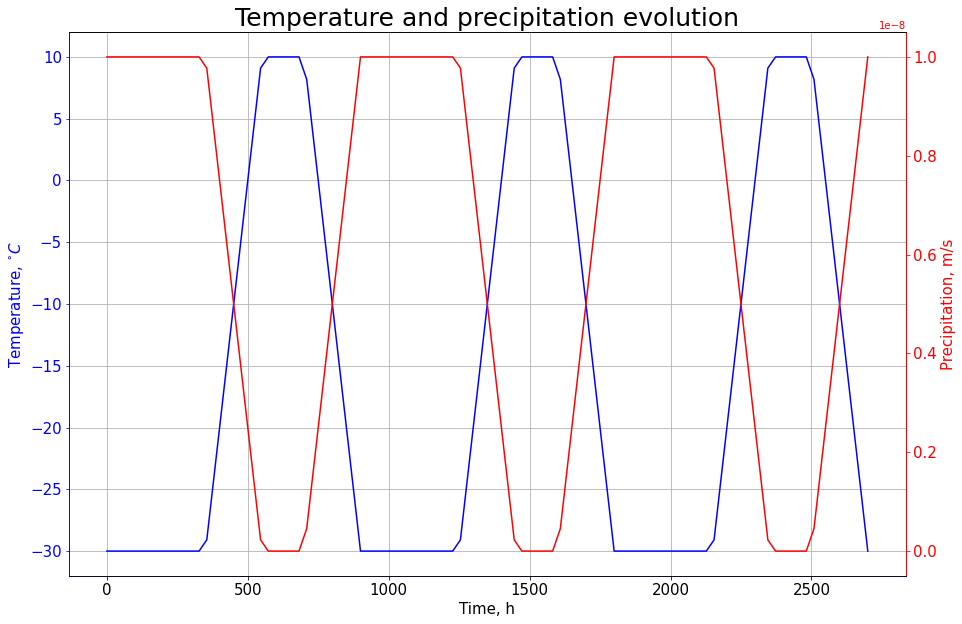

In [7]:
time_arr = np.linspace(0, 3*year_time, 100)

fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.set_title('Temperature and precipitation evolution', size=25)
ax2 = ax1.twinx()
ax1.plot(time_arr/3600.0,
         [linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                          lowest_temp, highest_temp,
                          lowest_p, highest_p, t)[0] for t in time_arr],
         label='tempreature', color='b')
ax2.plot(time_arr/3600.0,
         [linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                          lowest_temp, highest_temp,
                          lowest_p, highest_p, t)[1] for t in time_arr],
         label='precipitation', color='r')
ax1.spines['bottom'].set_color('b')
ax1.set_xlabel('Time, h', size=15)
ax1.set_ylabel(r'Temperature, $^{\circ}C$', size=15)
ax2.set_ylabel(r'Precipitation, m/s', size=15)
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.spines['left'].set_color('b')
ax1.tick_params(axis='y', colors='b')
ax1.yaxis.label.set_color('b')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
ax1.grid()
plt.savefig('imgs/temp_and_prec.png')
plt.show()

In [ ]:
dzi_arr, dzs_arr,\
timeline,\
temp_oi_arr, temp_ice_arr, temp_is_arr, temp_snow_arr, temp_sa_arr,\
rho_ice_arr,\
snow_filter = ue.main_process\
(
    time_step=3600.0,
    time_end=3*year_time,
    N_pseudoiter=25,
    Ti_init=ue.Tf_w + np.arange(0.5, Ni)/Ni * (Tis_init - ue.Tf_w),
    Ts_init=Tis_init + np.arange(0.5, Ns)/Ns * (Tsa_init - Tis_init),
    Toi_init=ue.Tf_w,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=salinity_init,
    snow_thickness_threshold=0.05,
    To = lambda t: ue.Tf_w,
    Ta = lambda t: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                   lowest_temp, highest_temp,
                                   lowest_p, highest_p, t)[0],
    p = lambda t: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                   lowest_temp, highest_temp,
                                   lowest_p, highest_p, t)[1],
    F_sw = lambda t: 100.0,
    u_a = lambda t: 15.0
)

In [ ]:
end_proc = -1

vis_year = uv.animate(dzi_arr[:end_proc], dzs_arr[:end_proc],
                      temp_oi_arr[:end_proc], temp_ice_arr[:end_proc], temp_is_arr[:end_proc], temp_snow_arr[:end_proc], temp_sa_arr[:end_proc],
                      timeline[:end_proc],
                      rho_ice_arr[:end_proc], ue.rho_w,ue.rho_s,
                      snow_filter[:end_proc])

vis_year

In [ ]:
vis_year.save("3year.mp4", dpi=200)

In [ ]:
def sec_order(arr, dz):
    first_order = np.gradient(arr, np.cumsum(dz) - dz/2, edge_order=2)
    second_order = np.gradient(first_order, np.cumsum(dz) - dz/2, edge_order=2)
    return second_order

In [ ]:
avg_abs_secord_winter = np.average([np.abs(sec_order(temp_ice, dzi))[1:-1]\
                                    for temp_ice, dzi\
                                    in zip(np.concatenate((temp_ice_arr[:350],
                                                          temp_ice_arr[900:1250],
                                                          temp_ice_arr[1800:2150])),
                                           np.concatenate((dzi_arr[:350],
                                                          dzi_arr[900:1250],
                                                          dzi_arr[1800:2150])))],
                                   axis=0)

avg_abs_secord_spring = np.average([np.abs(sec_order(temp_ice, dzi))[1:-1]\
                                    for temp_ice, dzi\
                                    in zip(np.concatenate((temp_ice_arr[350:550],
                                                          temp_ice_arr[1250:1450],
                                                          temp_ice_arr[2150:2350])),
                                           np.concatenate((dzi_arr[350:550],
                                                          dzi_arr[1250:1450],
                                                          dzi_arr[2150:2350])))],
                                   axis=0)

avg_abs_secord_summer = np.average([np.abs(sec_order(temp_ice, dzi))[1:-1]\
                                    for temp_ice, dzi\
                                    in zip(np.concatenate((temp_ice_arr[550:700],
                                                          temp_ice_arr[1450:1600],
                                                          temp_ice_arr[2350:2500])),
                                           np.concatenate((dzi_arr[550:700],
                                                          dzi_arr[1450:1600],
                                                          dzi_arr[2350:2500])))],
                                   axis=0)

avg_abs_secord_autumn = np.average([np.abs(sec_order(temp_ice, dzi))[1:-1]\
                                    for temp_ice, dzi\
                                    in zip(np.concatenate((temp_ice_arr[700:900],
                                                          temp_ice_arr[1600:1800],
                                                          temp_ice_arr[2500:2700])),
                                           np.concatenate((dzi_arr[700:900],
                                                          dzi_arr[1600:1800],
                                                          dzi_arr[2500:2700])))],
                                   axis=0)

avg_abs_secord_year = np.average([np.abs(sec_order(temp_ice, dzi))[1:-1]\
                                    for temp_ice, dzi\
                                    in zip(temp_ice_arr, dzi_arr)],
                                   axis=0)

In [ ]:
plt.figure(figsize=(15, 10))
plt.title("Average magnitude of temperature second derivative", size=25)
plt.plot(avg_abs_secord_winter, np.linspace(1/Ni, 1-1/Ni, Ni-2), label='winter')
plt.plot(avg_abs_secord_spring, np.linspace(1/Ni, 1-1/Ni, Ni-2), label='spring')
plt.plot(avg_abs_secord_summer, np.linspace(1/Ni, 1-1/Ni, Ni-2), label='summer')
plt.plot(avg_abs_secord_autumn, np.linspace(1/Ni, 1-1/Ni, Ni-2), label='autumn')
plt.plot(avg_abs_secord_year, np.linspace(1/Ni, 1-1/Ni, Ni-2), label='year', lw=5, alpha=0.5)
plt.xlabel(r'Second derivative of temperature, $^{\circ}C/m^2$', size=20)
plt.ylabel('Sigma-coordinate', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size':20})
plt.grid()
plt.savefig('imgs/secord_magnitude.png')
plt.show()

## 7. Точное решение для круглогодичного эксперимента

In [ ]:
Tis_init = -15.0
Tsa_init = -20.0
ice_thickness_init = 4.0
snow_thickness_init = 0.1
Ni = 100
Ns = 10
Ti_func_init = lambda z: (z*Tis_init + (ice_thickness_init-z)*ue.Tf_w)/ice_thickness_init
Ts_func_init = lambda z: (z*Tsa_init + (snow_thickness_init-z)*Tis_init)/snow_thickness_init
ice_cells_init = dzi_init.cumsum() - dzi_init/2
snow_cells_init = dzs_init.cumsum() - dzs_init/2
salinity_init = np.linspace(4.0, 1.0, Ni)

dzi_arr_exact, dzs_arr_exact,\
timeline_exact,\
temp_oi_arr_exact, temp_ice_arr_exact, temp_is_arr_exact, temp_snow_arr_exact, temp_sa_arr_exact,\
rho_ice_arr_exact,\
snow_filter_exact = ue.main_process\
(
    time_step=3600.0,
    time_end=3*year_time,
    N_pseudoiter=25,
    Ti_init=Ti_func_init(ice_cells_init),
    Ts_init=Ts_func_init(snow_cells_init),
    Toi_init=ue.Tf_w,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=salinity_init,
    snow_thickness_threshold=0.05,
    To = lambda t: ue.Tf_w,
    Ta = lambda t: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                   lowest_temp, highest_temp,
                                   lowest_p, highest_p, t)[0],
    p = lambda t: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                   lowest_temp, highest_temp,
                                   lowest_p, highest_p, t)[1],
    F_sw = lambda t: 100.0,
    u_a = lambda t: 15.0
)

In [ ]:
end_proc = -1

vis_year_exact = uv.animate(dzi_arr_exact[:end_proc], dzs_arr_exact[:end_proc],
                      temp_oi_arr_exact[:end_proc], temp_ice_arr_exact[:end_proc], temp_is_arr_exact[:end_proc], temp_snow_arr_exact[:end_proc], temp_sa_arr_exact[:end_proc],
                      timeline_exact[:end_proc],
                      rho_ice_arr_exact[:end_proc], ue.rho_w,ue.rho_s,
                      snow_filter_exact[:end_proc])

In [ ]:
%%time
vis_year_exact.save('year_exact.mp4', dpi=150)

In [ ]:
def thickening(N, s):
    if s == 0:
        return np.full(N, 1/N)
    else:
        return np.array([s*(1 - s)**i/(1 - (1 - s)**N) for i in range(N)])

In [ ]:
N = 15

plt.figure(figsize=(10, 6))
for s in np.arange(0, 0.16, 0.025):
    plt.plot([s]*(N+1), np.insert(np.cumsum(thickening(N, s)), 0,  0.0), marker='x', color='black')
plt.xticks(np.arange(0, 0.16, 0.025))
plt.xlabel('Level of thickening', size=20)
plt.ylabel('Sigma-coordinate', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('imgs/level_of_thickening.png')
plt.grid(ls='--')
plt.show()

In [ ]:
Ni = 8

dzi_arr_map = {}
dzs_arr_map = {}
timeline_map = {}
temp_oi_arr_map = {}
temp_ice_arr_map = {}
temp_is_arr_map = {}
temp_snow_arr_map = {}
temp_sa_arr_map = {}
rho_ice_arr_map = {}
snow_filter_map = {}

for s in tqdm(np.arange(0, 0.21, 0.05)):
    dzi_init = thickening(Ni, s)*ice_thickness_init
    ice_cells_init = dzi_init.cumsum() - dzi_init/2
    dzi_arr, dzs_arr,\
    timeline,\
    temp_oi_arr, temp_ice_arr, temp_is_arr, temp_snow_arr, temp_sa_arr,\
    rho_ice_arr,\
    snow_filter = ue.main_process\
    (
        time_step=3600.0,
        time_end=3*year_time,
        N_pseudoiter=25,
        Ti_init=Ti_func_init(ice_cells_init),
        Ts_init=Tis_init + np.arange(0.5, Ns)/Ns * (Tsa_init - Tis_init),
        Toi_init=ue.Tf_w,
        Tis_init=Tis_init,
        Tsa_init=Tsa_init,
        dzi_init=dzi_init,
        dzs_init=dzs_init,
        salinity=salinity_init,
        snow_thickness_threshold=0.05,
        To = lambda t: ue.Tf_w,
        Ta = lambda t: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                       lowest_temp, highest_temp,
                                       lowest_p, highest_p, t)[0],
        p = lambda t: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                       lowest_temp, highest_temp,
                                       lowest_p, highest_p, t)[1],
        F_sw = lambda t: 100.0,
        u_a = lambda t: 15.0
    )
    
    dzi_arr_map[s] = dzi_arr
    dzs_arr_map[s] = dzs_arr
    timeline_map[s] = timeline
    temp_oi_arr_map[s] = temp_oi_arr
    temp_ice_arr_map[s] = temp_ice_arr
    temp_is_arr_map[s] = temp_is_arr
    temp_snow_arr_map[s] = temp_snow_arr
    temp_sa_arr_map[s] = temp_sa_arr
    rho_ice_arr_map[s] = rho_ice_arr
    snow_filter_map[s] = snow_filter

In [ ]:
def bottomline(dzi, dzs, rho_i,ue.rho_s, ue.rho_w):
    return (-np.dot(dzi, rho_i) -ue.rho_s*sum(dzs))/rho_w

In [ ]:
def h_error(exact_dz, test_dz):
    return sum(exact_dz) - sum(test_dz)

In [ ]:
def bottomline_error(exact_sol_dzi, exact_sol_dzs, exact_sol_rho_i,
                     test_sol_dzi, test_sol_dzs, test_sol_rho_i,
                    ue.rho_s, ue.rho_w):
    return bottomline(exact_sol_dzi, exact_sol_dzs, exact_sol_rho_i,ue.rho_s, ue.rho_w) - \
           bottomline(test_sol_dzi, test_sol_dzs, test_sol_rho_i,ue.rho_s, ue.rho_w)

In [ ]:
def T_error(exact_sol_dz, exact_sol_T, test_sol_dz, test_sol_T):
    test_sol_dz_new = exact_sol_dz*test_sol_dz.sum()/exact_sol_dz.sum()
    test_sol_T_new = np.interp(test_sol_dz_new.cumsum() - test_sol_dz_new/2,
                               test_sol_dz.cumsum() - test_sol_dz/2,
                               test_sol_T)
    return np.sqrt(np.mean(exact_sol_T - test_sol_T_new)**2)

In [ ]:
def twoD_error(exact_sol_dzi, exact_sol_dzs, exact_sol_T, exact_sol_rho_i,
               test_sol_dzi, test_sol_dzs, test_sol_T, test_sol_rho_i,
              ue.rho_s, ue.rho_w):
    test_sol_dzi_new = exact_sol_dzi*test_sol_dzi.sum()/exact_sol_dzi.sum()
    test_sol_T_new = np.interp(test_sol_dzi_new.cumsum() - test_sol_dzi_new/2,
                               test_sol_dzi.cumsum() - test_sol_dzi/2,
                               test_sol_T)
    exact_bottomline = bottomline(exact_sol_dzi, exact_sol_dzs, exact_sol_rho_i,ue.rho_s, ue.rho_w)
    test_bottomline = bottomline(test_sol_dzi, test_sol_dzs, test_sol_rho_i,ue.rho_s, ue.rho_w)
    exact_Z = np.cumsum(exact_sol_dzi) - exact_sol_dzi/2 + exact_bottomline
    test_Z = np.cumsum(test_sol_dzi_new) - test_sol_dzi_new/2 + test_bottomline
    return np.sqrt(np.mean([((e_Z - t_Z)/(exact_Z.max() - exact_Z.min()))**2 + \
                            ((e_T - t_T)/(exact_sol_T.max() - exact_sol_T.min()))**2 \
                            for e_Z, e_T, t_Z, t_T \
                            in zip(exact_Z, exact_sol_T, test_Z, test_sol_T_new)]))

In [ ]:
plt.figure(figsize=(40, 10))
plt.title('Thickness error', size=25)
for s in tqdm(dzi_arr_map.keys()):
    plt.plot(np.array(timeline_map[s])/3600.0,
             [h_error(dzi_exact, dzi_test) for dzi_exact, dzi_test in zip(dzi_arr_exact, dzi_arr_map[s])],
             label="s = {:.2f}".format(s))
plt.xlabel('time, h.', size=20)
plt.ylabel(r'$Error, m.$', size=20)
plt.xticks(np.arange(0, timeline_map[s][-1]/3600.0, 100), fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size':20})
plt.grid()
plt.savefig('imgs/errors_h.png')
plt.plot()

In [ ]:
plt.figure(figsize=(40, 10))
plt.title('T error', size=25)
for s in tqdm(dzi_arr_map.keys()):
    plt.plot(np.array(timeline_map[s])/3600.0,
             [T_error(dzi_exact, T_exact, dzi_test, T_test)\
              for dzi_exact, T_exact, dzi_test, T_test\
              in zip(dzi_arr_exact, temp_ice_arr_exact, dzi_arr_map[s], temp_ice_arr_map[s])],
             label="s = {:.2f}".format(s))
plt.xlabel('time, h.', size=20)
plt.ylabel(r'$Error, ^\circ C$', size=20)
plt.xticks(np.arange(0, timeline_map[s][-1]/3600.0, 100), fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size':20})
plt.grid()
plt.savefig('imgs/errors_T.png')
plt.plot()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(dzi_arr_exact[-1].cumsum() - dzi_arr_exact[-1]/2, temp_ice_arr_exact[-1], label='exact sol')
plt.plot(dzi_arr_map[0.2][-1].cumsum() - dzi_arr_map[0.2][-1]/2, temp_ice_arr_map[0.2][-1], label='test sol')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(40, 10))
plt.title('2D error')
for s in tqdm(np.arange(0, 0.16, 0.025)):
    plt.plot(np.array(timeline_map[s])/3600.0,
             [twoD_error(dzi_exact, dzs_exact, T_exact, rho_i_exact,
                         dzi_test, dzs_test, T_test, rho_i_test,
                        ue.rho_s, ue.rho_w)\
              for dzi_exact, dzs_exact, T_exact, rho_i_exact, dzi_test, dzs_test, T_test, rho_i_test\
              in zip(dzi_arr_exact, dzs_arr_exact, temp_ice_arr_exact, rho_ice_arr_exact,
                     dzi_arr_map[s], dzs_arr_map[s], temp_ice_arr_map[s], rho_ice_arr_map[s])],
             label="s = {:.2f}".format(s))
plt.legend()
plt.grid()
plt.plot()

In [ ]:
plt.figure(figsize=(40, 10))
plt.title('Bottomline error')
for s in tqdm(dzi_arr_map.keys()):
    plt.plot(np.array(timeline_map[s])/3600.0, 
             [bottomline_error(dzi_exact, dzs_exact, rho_i_exact,
                               dzi_test, dzs_test, rho_i_test,
                              ue.rho_s, ue.rho_w)\
              for dzi_exact, dzs_exact, rho_i_exact, dzi_test, dzs_test, rho_i_test\
              in zip(dzi_arr_exact, dzs_arr_exact, rho_ice_arr_exact,
                     dzi_arr_map[s], dzs_arr_map[s], rho_ice_arr_map[s])],
             label="s = {:.2f}".format(s))
plt.legend()
plt.grid()
plt.savefig('imgs/errors_bottomline.png')
plt.plot()

In [ ]:
end_proc = -1
s = list(dzi_arr_map.keys())[-2]

vis_year_test = uv.animate(dzi_arr_map[s][:end_proc], dzs_arr_map[s][:end_proc],
                           temp_oi_arr_map[s][:end_proc], temp_ice_arr_map[s][:end_proc],
                           temp_is_arr_map[s][:end_proc], temp_snow_arr_map[s][:end_proc],
                           temp_sa_arr_map[s][:end_proc],
                           timeline_map[s][:end_proc],
                           rho_ice_arr_map[s][:end_proc], ue.rho_w,ue.rho_s,
                           snow_filter_map[s][:end_proc])

In [ ]:
vis_year_test.save('imgs/thick_3year.mp4', dpi=150)

In [ ]:
ice_cells_init

In [ ]:
s = 0.15

dzi_arr_map_n = {}
dzs_arr_map_n = {}
timeline_map_n = {}
temp_oi_arr_map_n = {}
temp_ice_arr_map_n = {}
temp_is_arr_map_n = {}
temp_snow_arr_map_n = {}
temp_sa_arr_map_n = {}
rho_ice_arr_map_n = {}
snow_filter_map_n = {}

for Ni in tqdm([5, 8, 10, 15, 20]):
    dzi_init = thickening(Ni, s)*ice_thickness_init
    ice_cells_init = dzi_init.cumsum() - dzi_init/2
    salinity_init = np.linspace(4.0, 1.0, Ni)
    dzi_arr, dzs_arr,\
    timeline,\
    temp_oi_arr, temp_ice_arr, temp_is_arr, temp_snow_arr, temp_sa_arr,\
    rho_ice_arr,\
    snow_filter = ue.main_process\
    (
        time_step=3600.0,
        time_end=3*year_time,
        N_pseudoiter=25,
        Ti_init=Ti_func_init(ice_cells_init),
        Ts_init=Tis_init + np.arange(0.5, Ns)/Ns * (Tsa_init - Tis_init),
        Toi_init=ue.Tf_w,
        Tis_init=Tis_init,
        Tsa_init=Tsa_init,
        dzi_init=dzi_init,
        dzs_init=dzs_init,
        salinity=salinity_init,
        snow_thickness_threshold=0.05,
        To = lambda t: ue.Tf_w,
        Ta = lambda t: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                       lowest_temp, highest_temp,
                                       lowest_p, highest_p, t)[0],
        p = lambda t: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                       lowest_temp, highest_temp,
                                       lowest_p, highest_p, t)[1],
        F_sw = lambda t: 100.0,
        u_a = lambda t: 15.0
    )
    
    dzi_arr_map_n[Ni] = dzi_arr
    dzs_arr_map_n[Ni] = dzs_arr
    timeline_map_n[Ni] = timeline
    temp_oi_arr_map_n[Ni] = temp_oi_arr
    temp_ice_arr_map_n[Ni] = temp_ice_arr
    temp_is_arr_map_n[Ni] = temp_is_arr
    temp_snow_arr_map_n[Ni] = temp_snow_arr
    temp_sa_arr_map_n[Ni] = temp_sa_arr
    rho_ice_arr_map_n[Ni] = rho_ice_arr
    snow_filter_map_n[Ni] = snow_filter

In [ ]:
plt.figure(figsize=(40, 10))
plt.title('Thickness error', size=25)
for Ni in dzi_arr_map_n.keys():
    plt.plot(np.array(timeline_map_n[Ni])/3600.0,
             [h_error(dzi_exact, dzi_test) for dzi_exact, dzi_test\
              in zip(dzi_arr_exact, dzi_arr_map_n[Ni])],
             label="N = {}".format(Ni))
plt.xlabel('time, h.', size=20)
plt.ylabel(r'$Error, m.$', size=20)
plt.xticks(np.arange(0, timeline_map_n[Ni][-1]/3600.0, 100), fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size':20})
plt.grid()
plt.savefig('imgs/N_errors_h.png')
plt.plot()

In [ ]:
plt.figure(figsize=(40, 10))
plt.title('T error', size=25)
for Ni in dzi_arr_map_n.keys():
    plt.plot(np.array(timeline_map_n[Ni])/3600.0,
             [T_error(dzi_exact, T_exact, dzi_test, T_test)\
              for dzi_exact, T_exact, dzi_test, T_test\
              in zip(dzi_arr_exact, temp_ice_arr_exact, dzi_arr_map_n[Ni], temp_ice_arr_map_n[Ni])],
             label="N = {}".format(Ni))
plt.xlabel('time, h.', size=20)
plt.ylabel(r'$Error, ^\circ C$', size=20)
plt.xticks(np.arange(0, timeline_map_n[Ni][-1]/3600.0, 100), fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size':20})
plt.grid()
plt.savefig('imgs/N_errors_T.png')
plt.plot()

In [ ]:
plt.figure(figsize=(40, 10))
plt.title('Bottomline error')
for Ni in tqdm(dzi_arr_map_n.keys()):
    plt.plot(np.array(timeline_map_n[Ni])/3600.0, 
             [bottomline_error(dzi_exact, dzs_exact, rho_i_exact,
                               dzi_test, dzs_test, rho_i_test,
                              ue.rho_s, ue.rho_w)\
              for dzi_exact, dzs_exact, rho_i_exact, dzi_test, dzs_test, rho_i_test\
              in zip(dzi_arr_exact, dzs_arr_exact, rho_ice_arr_exact,
                     dzi_arr_map_n[Ni], dzs_arr_map_n[Ni], rho_ice_arr_map_n[Ni])],
             label="N = {}".format(Ni))
plt.legend()
plt.grid()
plt.savefig('imgs/N_errors_bottomline.png')
plt.plot()